In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70
plt.rcParams['figure.figsize'] = [10, 5]
from pathlib import Path

from parsing.zero_coupon import ZeroCoupon
import statsmodels.api as sm

##### Риск-факторы:

* IMOEX
* RTSI с поправкой на индикативный курс USDRUB ЦБ
* Доллар
* Юань
* Кривая бескупонной доходности


In [36]:
_imoex_path = Path('..', 'data', 'index', 'history', 'IMOEX.csv')
_rtsi_path = Path('..', 'data', 'index', 'history', 'RTSI.csv')
_CB_rate_path = Path('..', 'data', 'credit_rate.csv')
_indicative_rate_path = Path('..', 'data', 'RUB_ind.csv')
_deposits_path = Path('..', 'data', 'deposits', 'RUB.pickle')
_CNY_Path = Path('..', 'data', 'currencies', 'history', 'CNYRUB_TOM.csv')
_USD_Path = Path('..', 'data', 'currencies', 'history', 'USD000UTSTOM.csv')

In [38]:
imoexDF = pd.read_csv(_imoex_path, index_col="TRADEDATE", usecols=["TRADEDATE", "CLOSE"])
imoexDF.index = pd.to_datetime(imoexDF.index)

rtsi_DF = pd.read_csv(_rtsi_path, usecols=["TRADEDATE", "CLOSE"])
rtsi_DF.TRADEDATE = pd.to_datetime(rtsi_DF.TRADEDATE).apply(lambda x: x.date())
rtsi_DF.set_index("TRADEDATE", inplace=True)
rtsi_USD_df = rtsi_DF.copy()

RUB_ind_rate = pd.read_csv(_indicative_rate_path).drop("#", axis=1)
RUB_ind_rate.moment = pd.to_datetime(RUB_ind_rate.moment).apply(lambda x: x.date())
RUB_ind_rate.set_index("moment", inplace=True)

rtsi_DF = rtsi_DF.mul(RUB_ind_rate, fill_value=1)
rtsi_DF["CLOSE"] = rtsi_DF["CLOSE"] * rtsi_DF["value"]
rtsi_DF.drop("value", inplace=True, axis=1)
rtsi_DF = rtsi_DF[~rtsi_DF.index.duplicated(keep='last')]
rtsi_DF.index = pd.to_datetime(rtsi_DF.index)

#CB_rate_df = pd.read_csv(_CB_rate_path, sep="\t", names=["date", "rate"])
#CB_rate_df.rate = CB_rate_df.rate.str.replace(",", ".").astype(float)
#CB_rate_df.set_index("date", inplace=True)
#CB_rate_df.index = pd.to_datetime(CB_rate_df.index)
#idx = pd.date_range("01-01-2016", "31-12-2021")
#CB_rate_df = CB_rate_df.reindex(idx).fillna(method="ffill")

CNY_df = pd.read_csv(_CNY_Path, usecols=["TRADEDATE", "CLOSE"])
CNY_df.TRADEDATE = pd.to_datetime(CNY_df.TRADEDATE).apply(lambda x: x.date())
CNY_df.set_index("TRADEDATE", inplace=True)


rtsi_DF.CLOSE = rtsi_DF.CLOSE.fillna(method="ffill")
CNY_df.CLOSE = CNY_df.fillna(method="ffill")
CNY_df.loc[pd.to_datetime("2019-05-03").date()] = CNY_df.loc[pd.to_datetime("2019-05-02").date()]

USD_df = pd.read_csv(_USD_Path, usecols=["TRADEDATE", "CLOSE"])
USD_df.TRADEDATE = pd.to_datetime(USD_df.TRADEDATE).apply(lambda x: x.date())
USD_df.set_index("TRADEDATE", inplace=True)

zeroCoupon = ZeroCoupon().returns()["rate_1.0"].to_frame()["rate_1.0"]
zeroCoupon = zeroCoupon.reindex(rtsi_DF.index).interpolate().to_frame().iloc[1:]

In [39]:
data = pd.DataFrame({'RTSI_RUB': rtsi_DF.pct_change().CLOSE.iloc[1:],
                     'RTSI_USD': rtsi_USD_df.pct_change().CLOSE.iloc[1:],
                     'IMOEX': imoexDF.pct_change().CLOSE.iloc[1:],
                     'CNY': CNY_df.pct_change().CLOSE.iloc[1:],
                     'USD': USD_df.pct_change().CLOSE.iloc[1:],
                      'ZeroCoupon': zeroCoupon["rate_1.0"]})

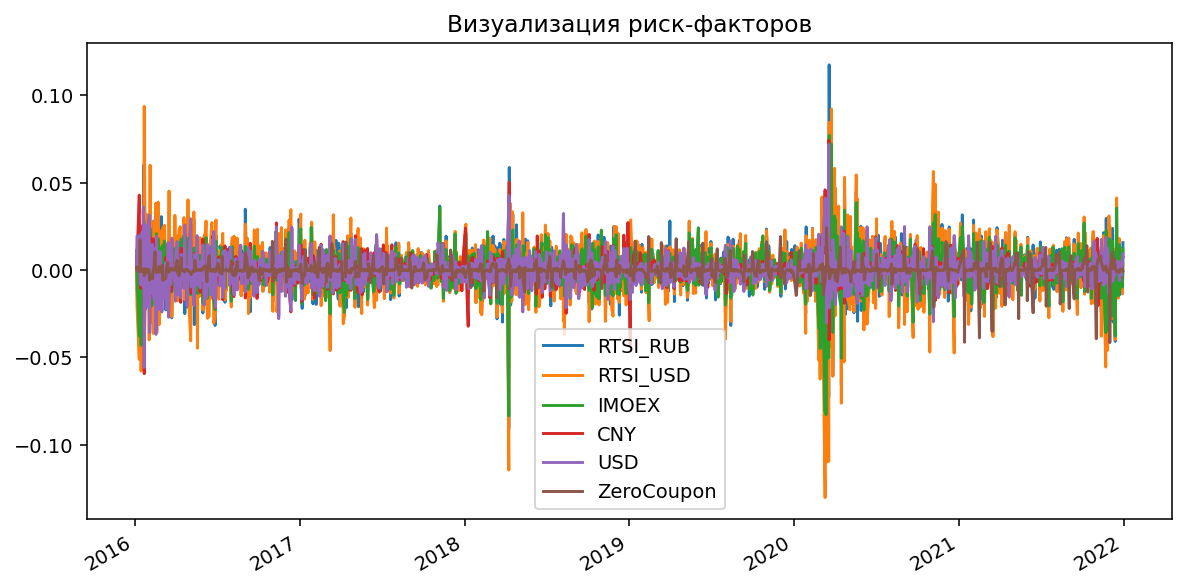

In [40]:
data.plot(title='Визуализация риск-факторов');

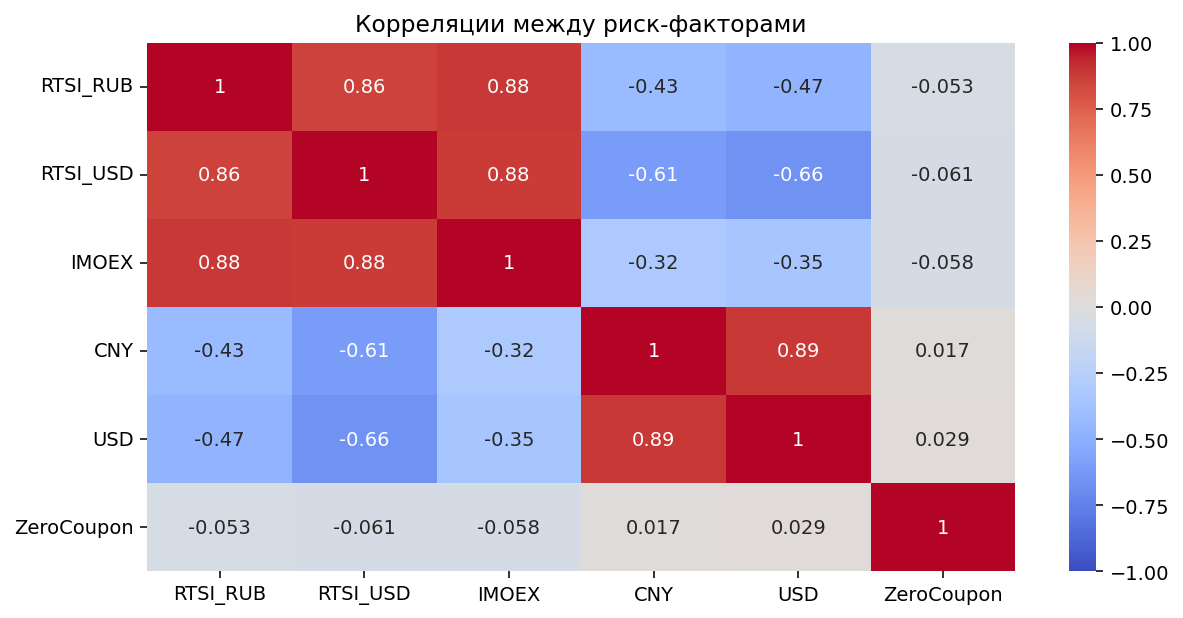

In [664]:
plt.title('Корреляции между риск-факторами')
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1);

array([[<AxesSubplot:title={'center':'CLOSE'}>]], dtype=object)

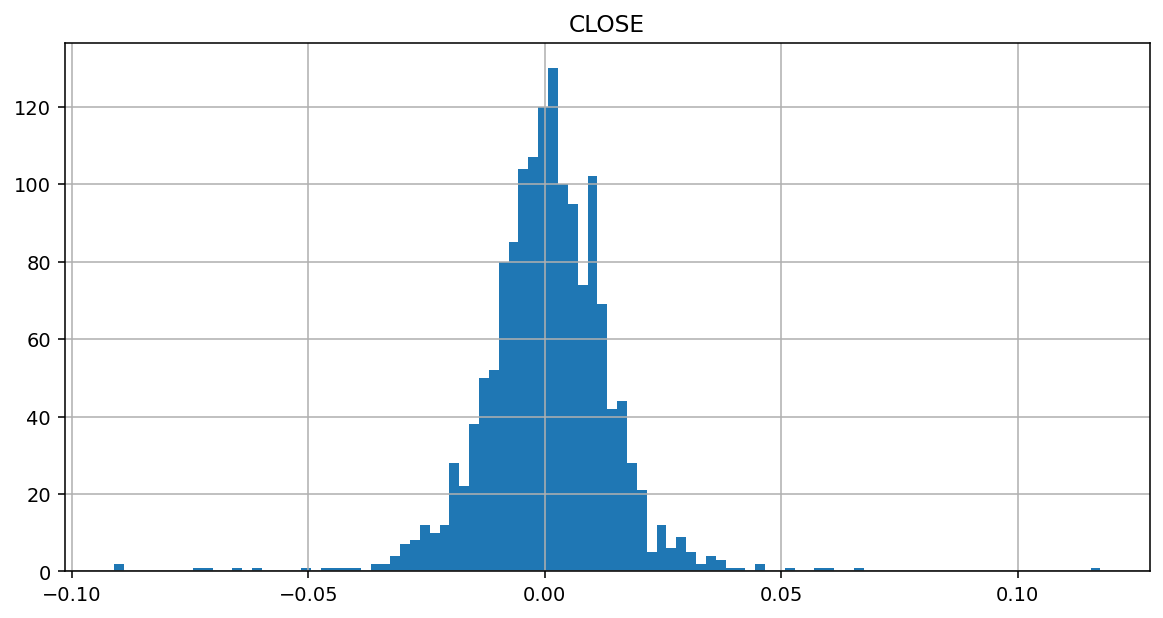

In [665]:
rtsi_DF.pct_change()[1:].CLOSE.to_frame().hist(bins=100)

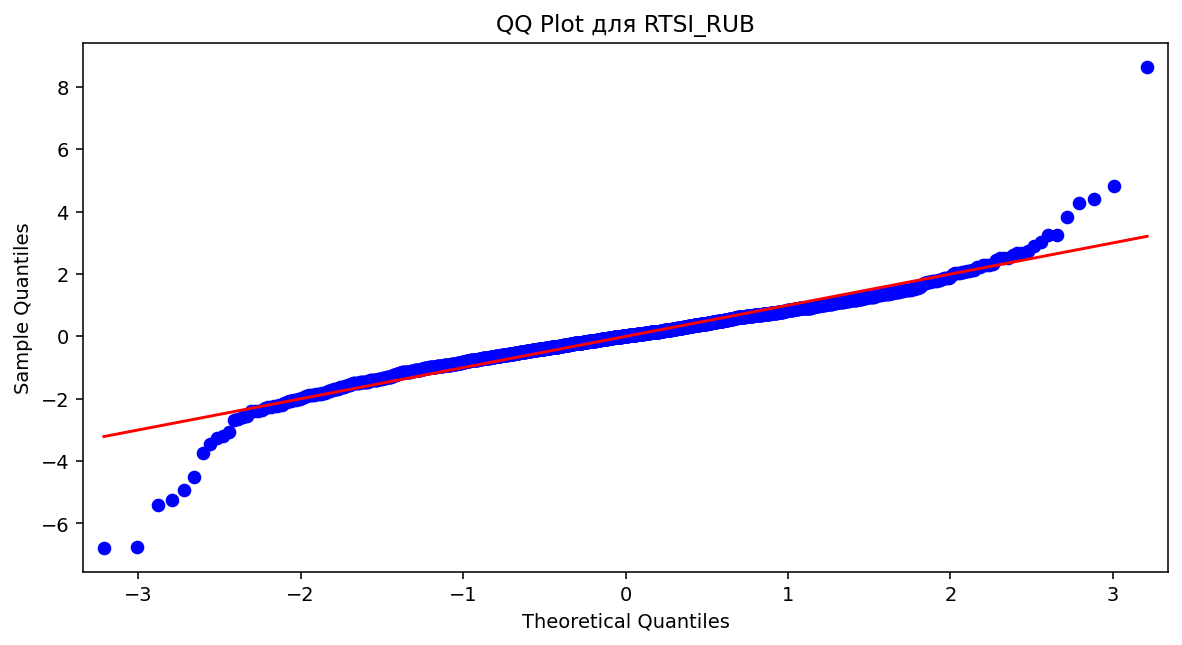

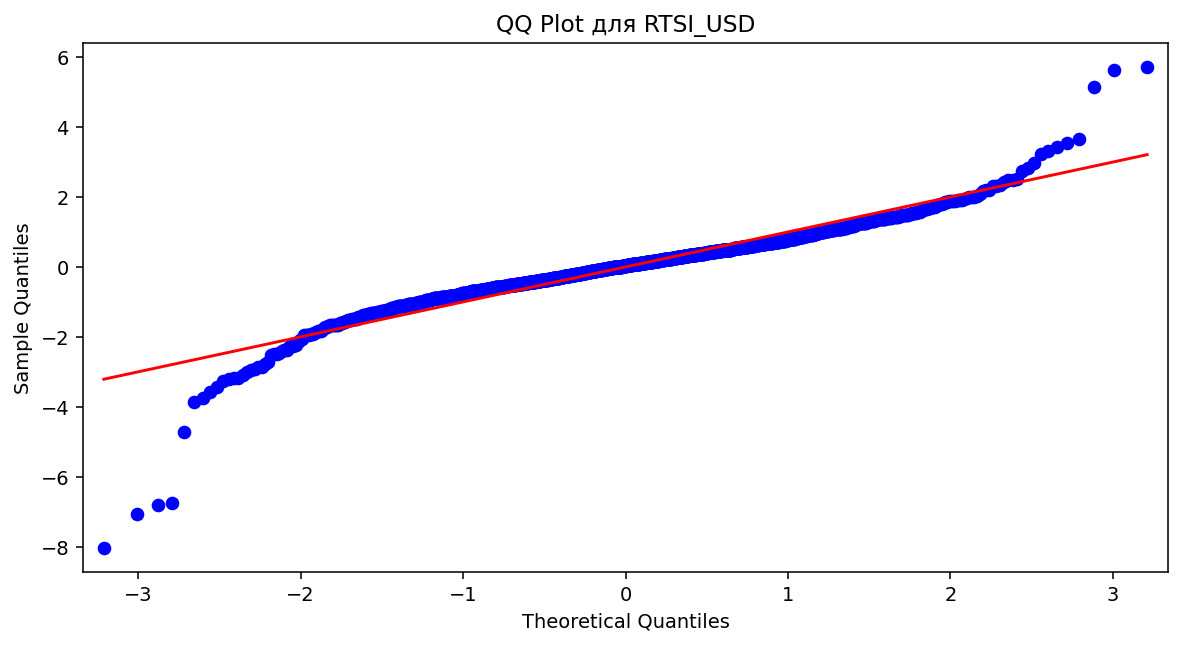

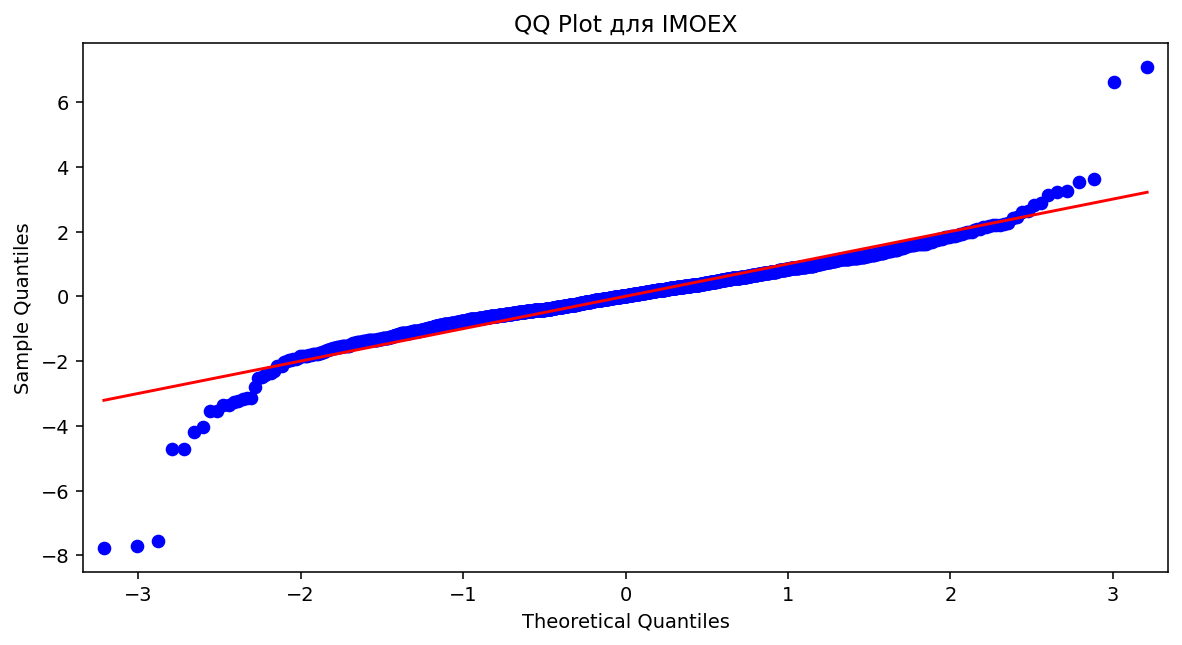

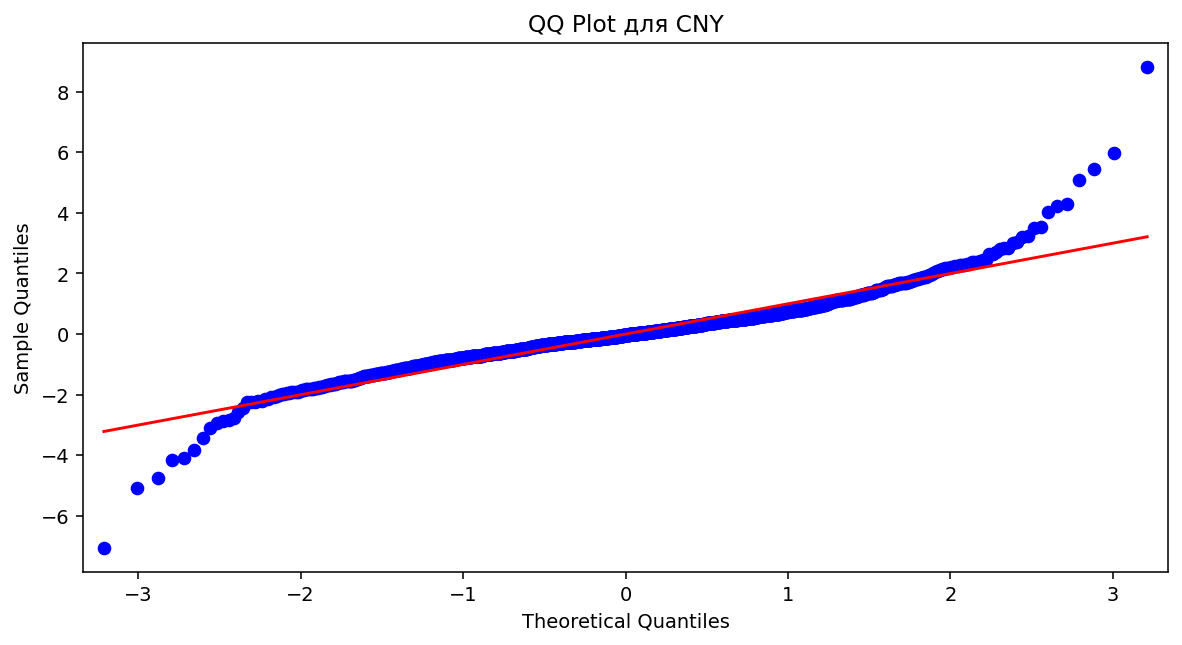

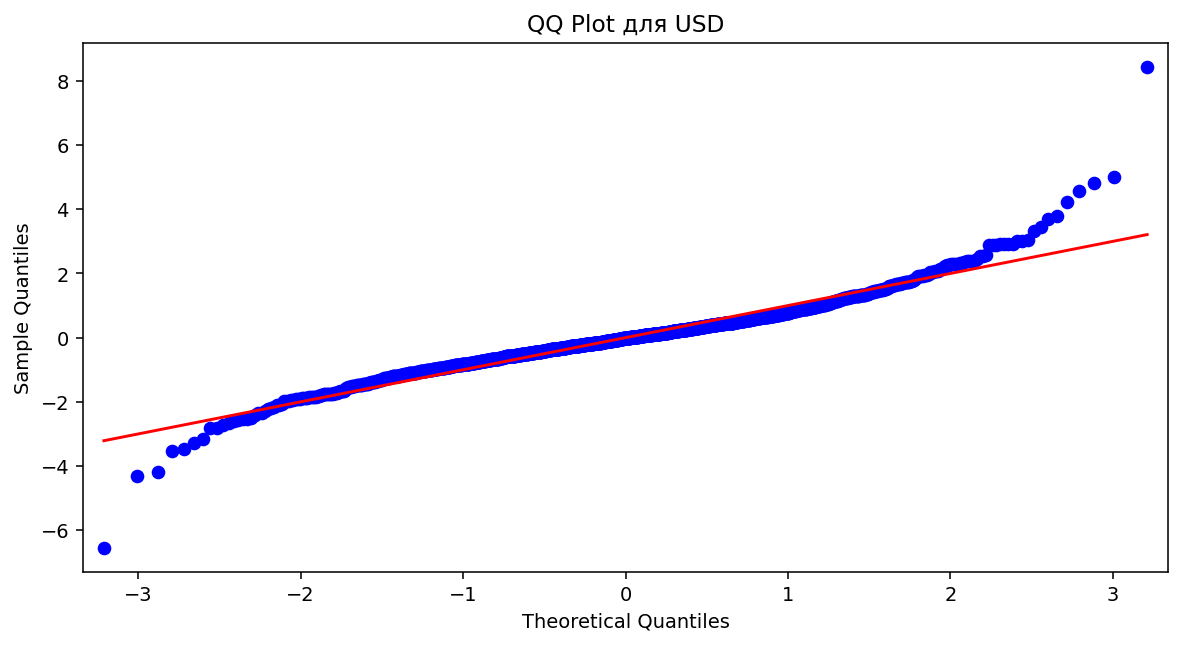

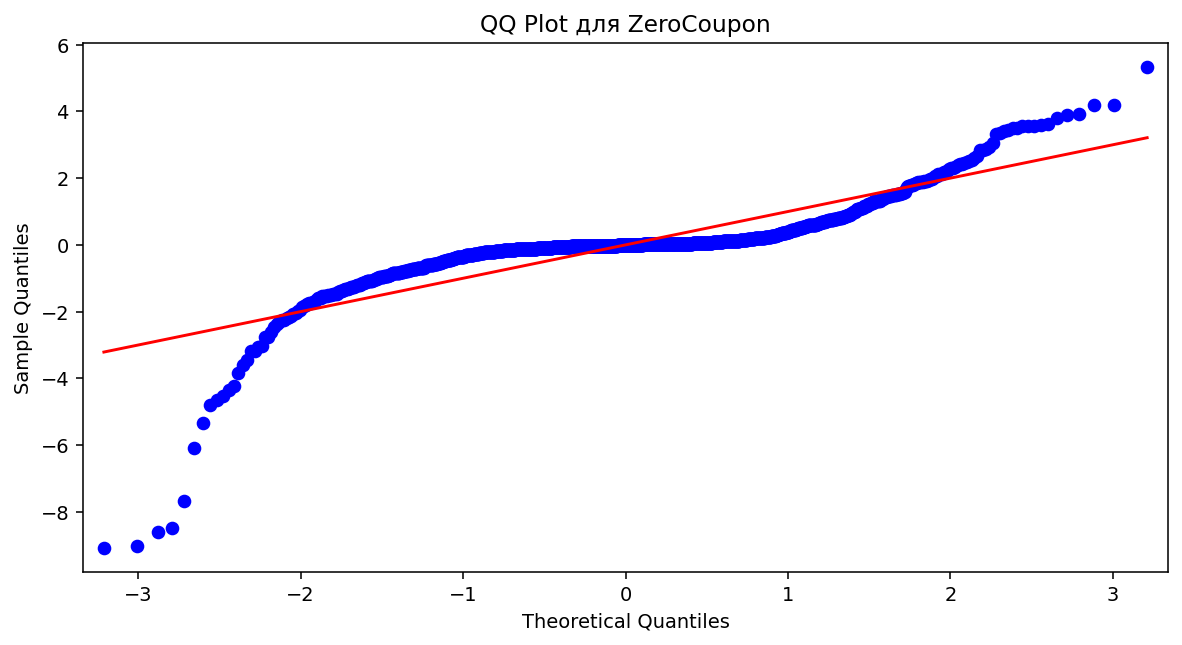

In [54]:
import warnings

for factor in data:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        sm.qqplot(data[factor], line="s", fit=True)

    plt.title(f'QQ Plot для {factor}')
    plt.show()

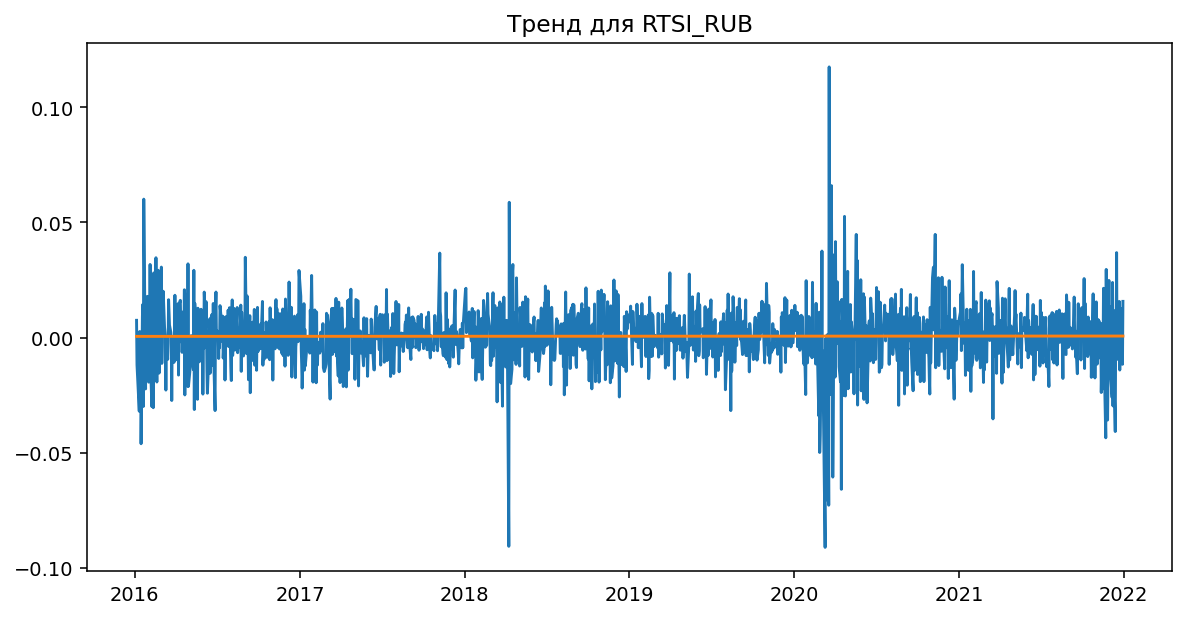

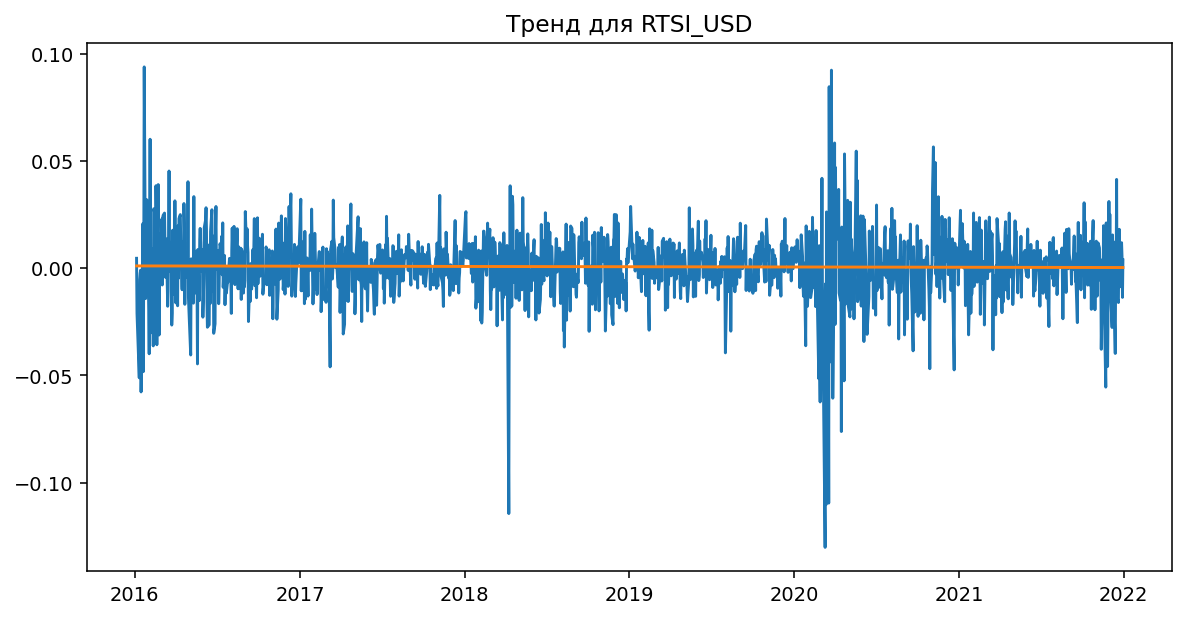

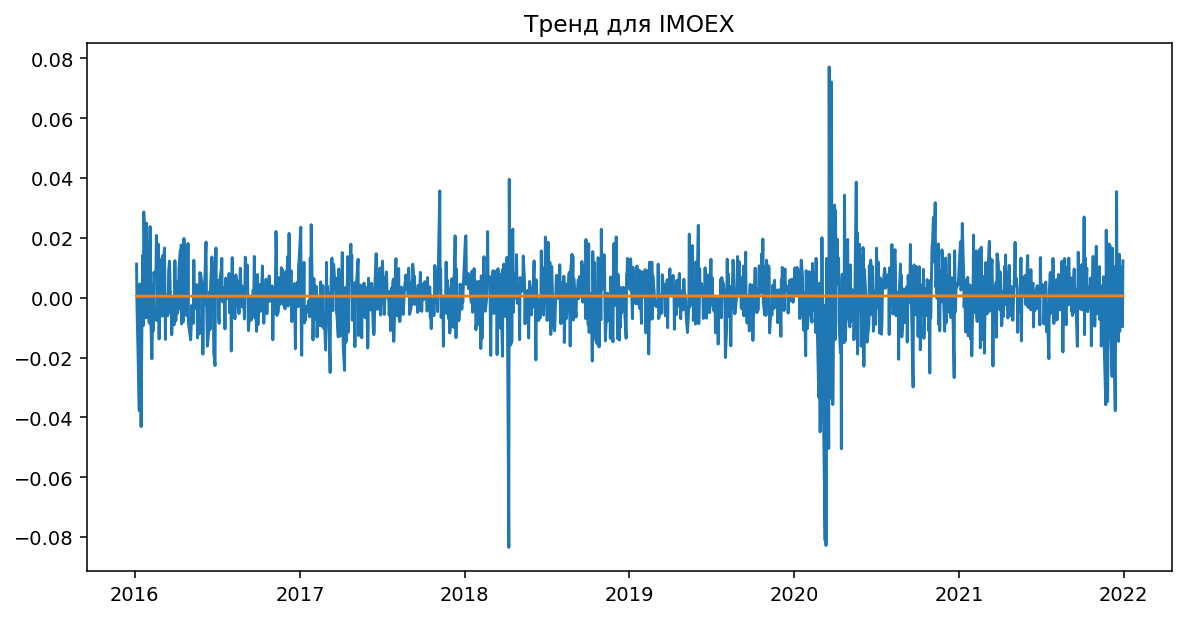

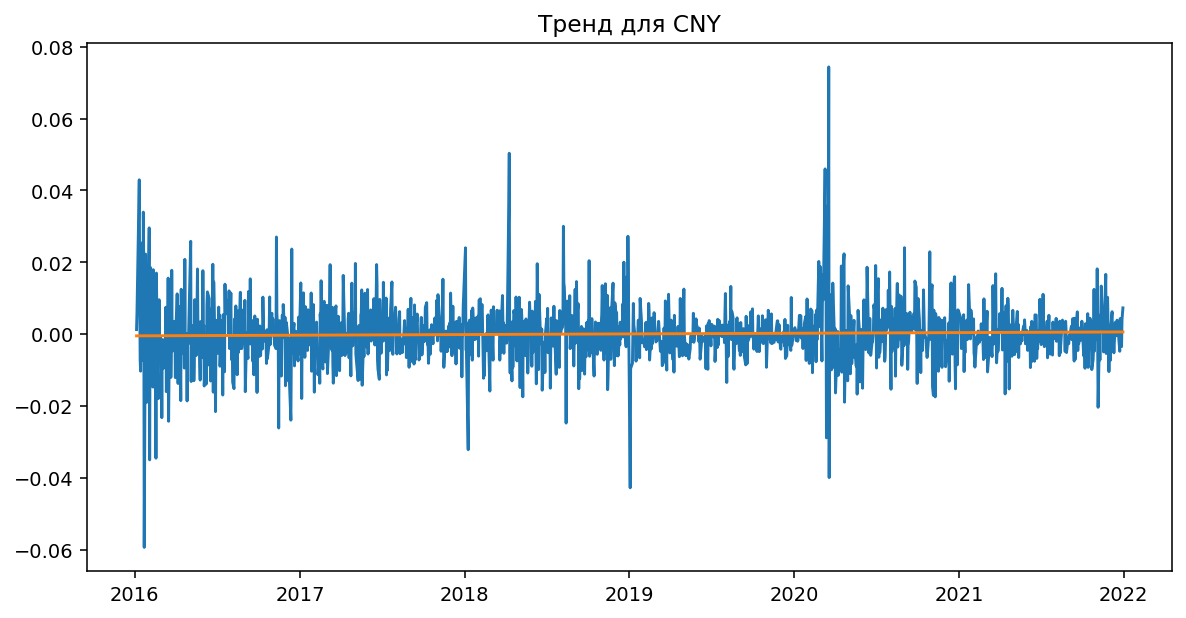

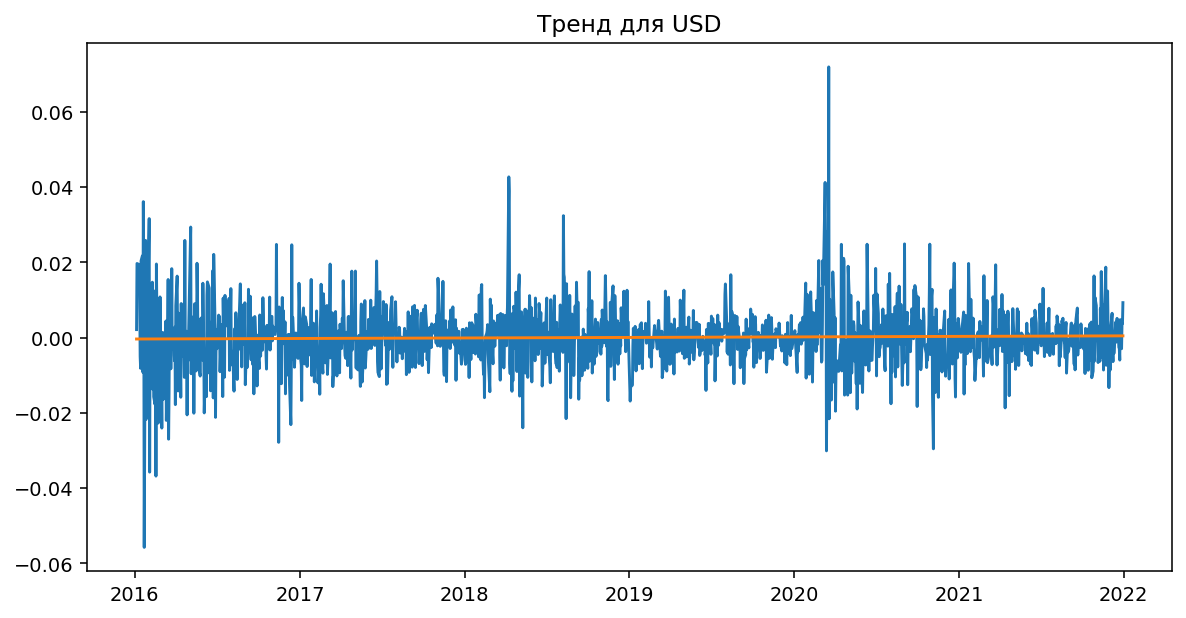

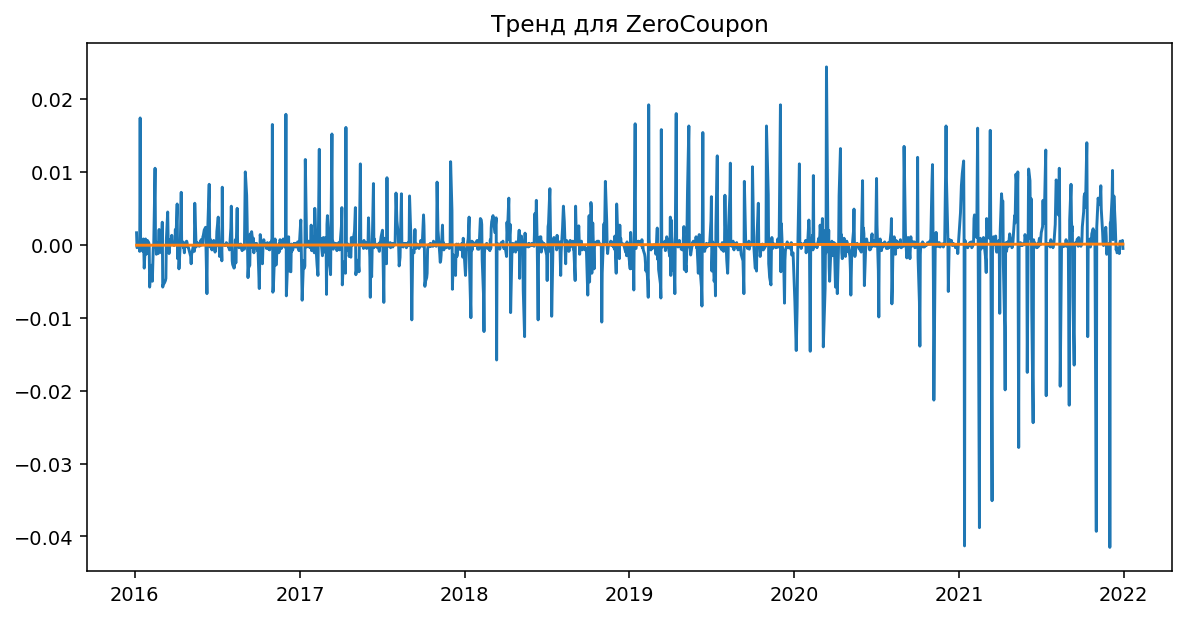

In [667]:
for factor in data:
    x = range(data.shape[0])
    trend_coefs = np.polyfit(x, data[factor], 1)
    trend = np.poly1d(trend_coefs)
    plt.plot(data[factor])
    plt.plot(data.index, trend(x))
    plt.title(f'Тренд для {factor}')
    plt.show()

Проверка на стационарность (для параметров аримы)

In [42]:
for factor in data:
    pval = sm.tsa.stattools.adfuller(data[factor])[1]
    print(factor)
    print(f"Критерий Дики-Фуллера: p={pval:.2}")
    print('На уровне значимости 5% гипотеза о нестационарности '
          + 'отвергается' if pval <= 0.05 else 'не отвергается')
    print()

RTSI_RUB
Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается

RTSI_USD
Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается

IMOEX
Критерий Дики-Фуллера: p=3.2e-30
На уровне значимости 5% гипотеза о нестационарности отвергается

CNY
Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается

USD
Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается

ZeroCoupon
Критерий Дики-Фуллера: p=1.8e-12
На уровне значимости 5% гипотеза о нестационарности отвергается



Для всех доходностей риск-факторов считаем, что они стационарны (следовательно d=0)

Коррелограммы:

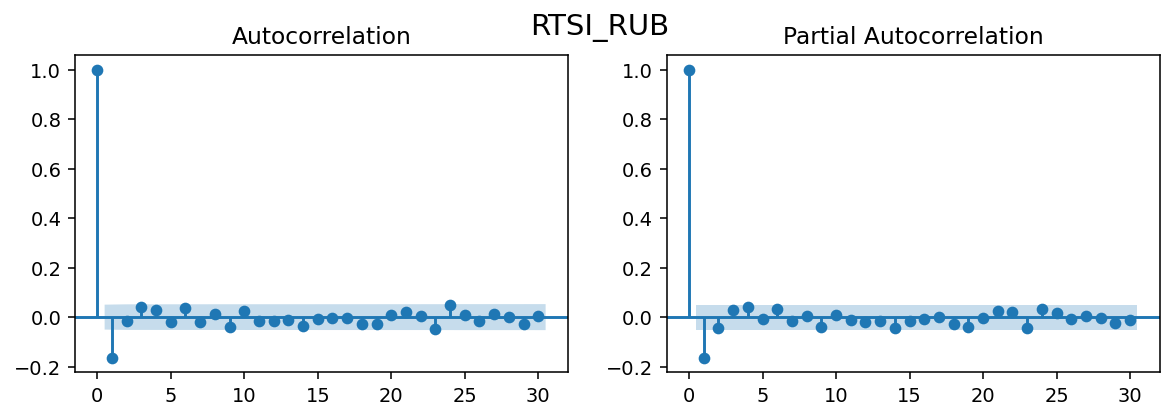

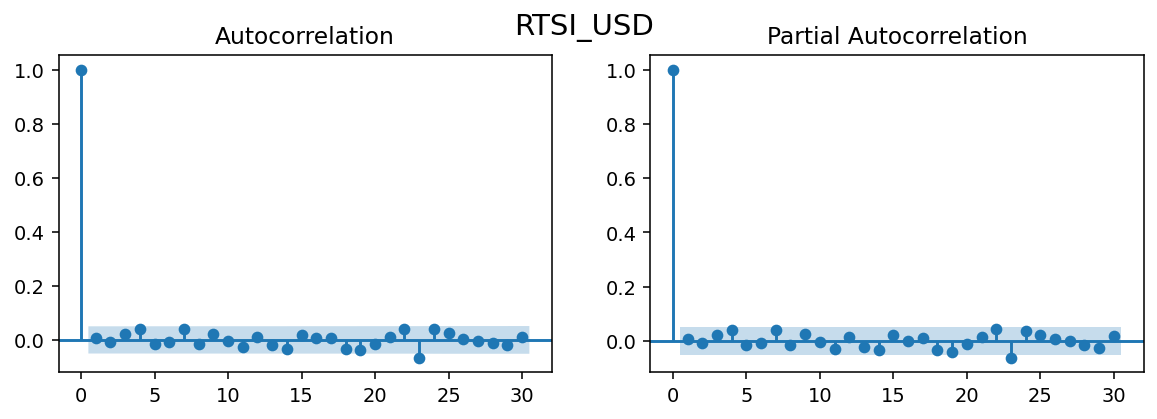

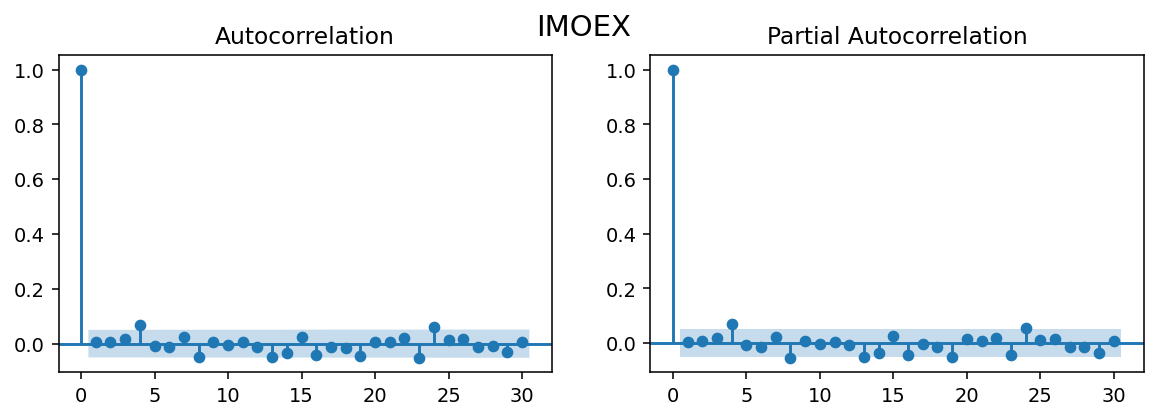

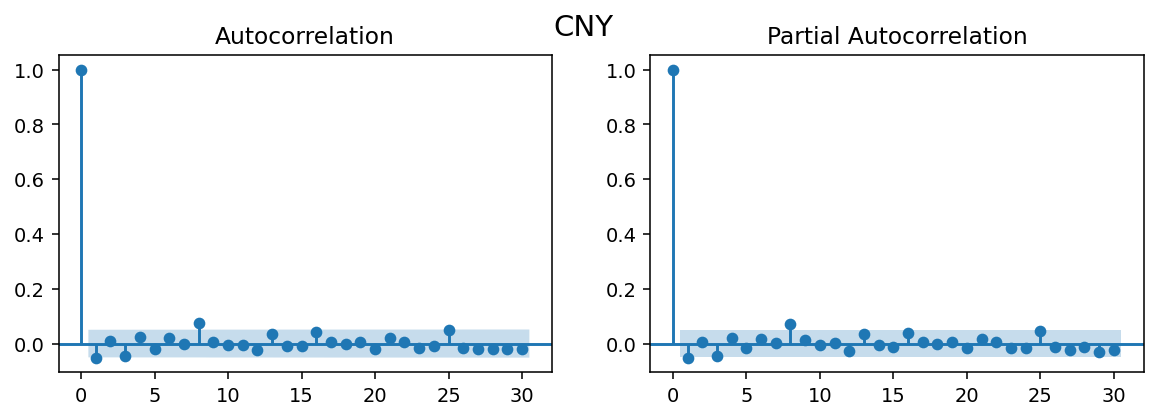

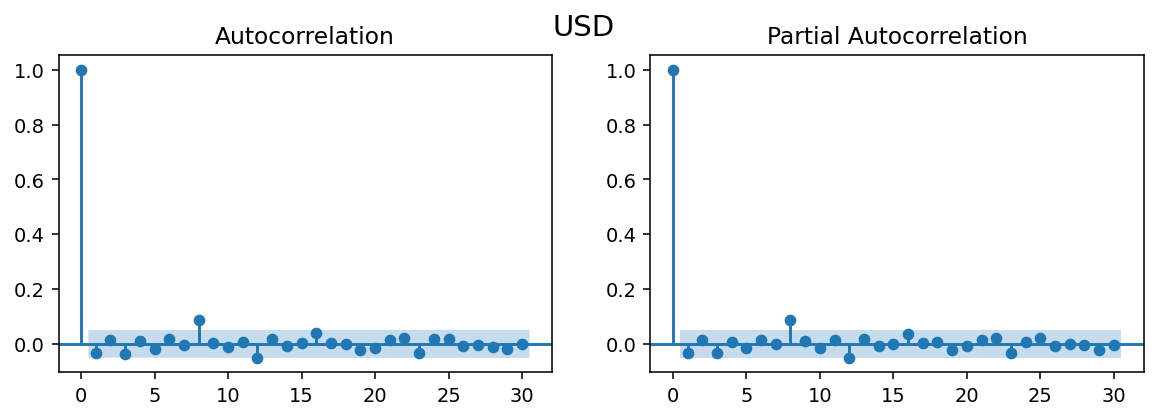

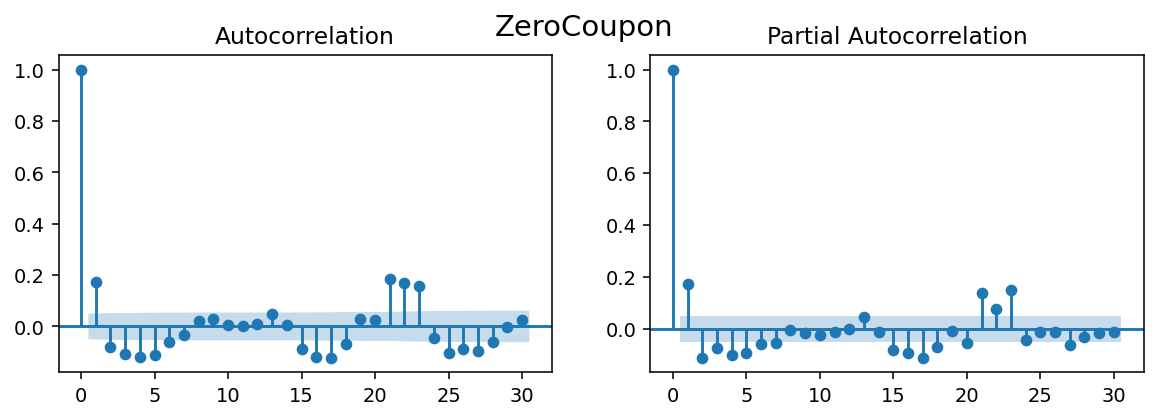

In [670]:
for factor in data:
    fig = plt.figure(figsize=(10, 3))
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))
    sm.graphics.tsa.plot_acf(data[factor], lags=30, ax=acf_ax, alpha=0.05)
    sm.graphics.tsa.plot_pacf(data[factor], lags=30, ax=pacf_ax, alpha=0.05, method='ywm')
    fig.suptitle(factor, fontsize=15)

Нетривиальный случай только у ZeroCoupon, наблюдается цикличность. Оценим параметры для сезонной составляющей

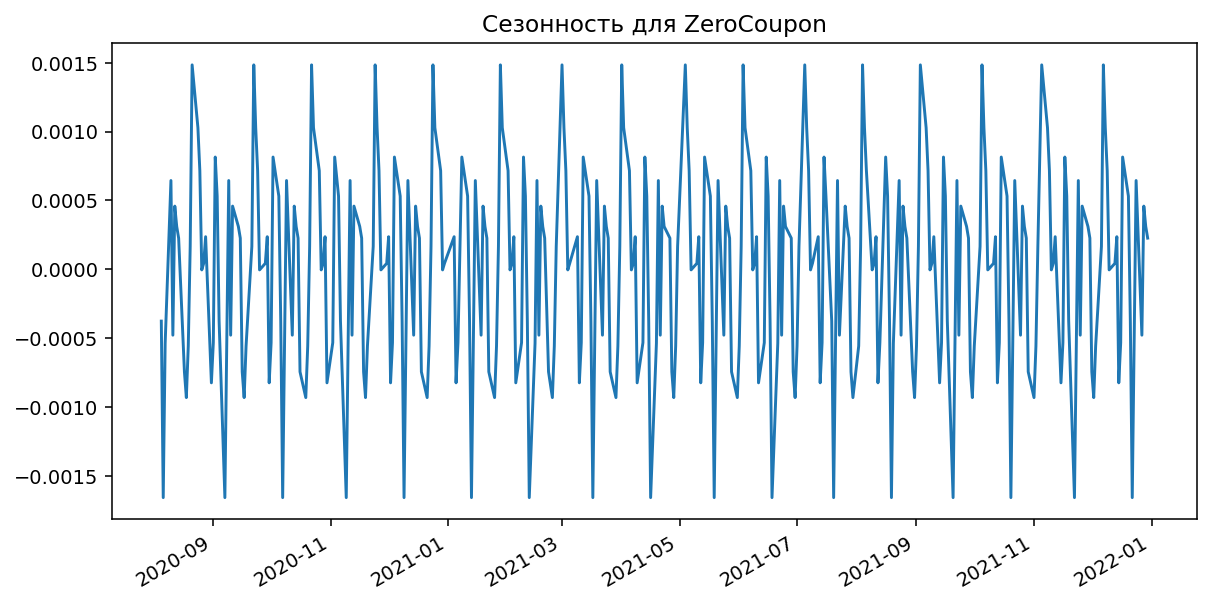

In [45]:
factor = 'ZeroCoupon'  # Единственный фактор с циклами в коррелограмме

season_data = sm.tsa.seasonal_decompose(data[factor], period=22)
season_data.seasonal.tail(360).plot()
plt.title(f'Сезонность для {factor}')
plt.show()

In [48]:
pval = sm.tsa.stattools.adfuller(season_data.seasonal)[1]
print(f"Критерий Дики-Фуллера: p={pval:.2}")
print('На уровне значимости 5% гипотеза о нестационарности '
      + 'отвергается' if pval <= 0.05 else 'не отвергается')

Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается


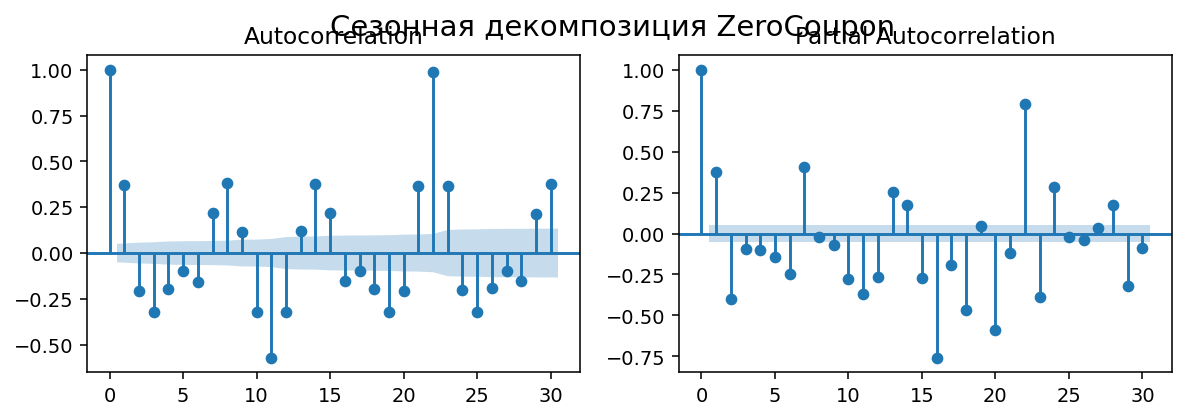

In [53]:
fig = plt.figure(figsize=(10, 3))
layout = (1, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))
sm.graphics.tsa.plot_acf(season_data.seasonal, lags=30, ax=acf_ax, alpha=0.05)
sm.graphics.tsa.plot_pacf(season_data.seasonal, lags=30, ax=pacf_ax, alpha=0.05, method='ywm')
fig.suptitle('Сезонная декомпозиция ZeroCoupon', fontsize=15);

PCA

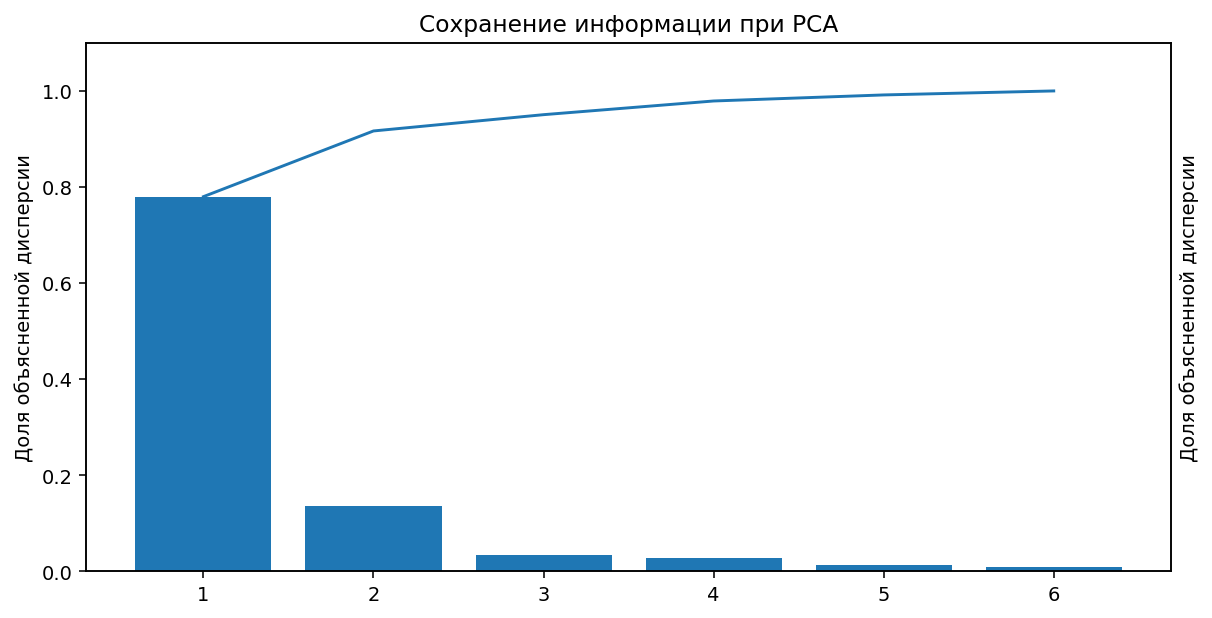

In [41]:
from sklearn.decomposition import PCA
pca = PCA().fit(data)

x = np.arange(1, len(pca.components_) + 1)
bar_y = pca.explained_variance_ratio_
y = np.cumsum(bar_y)

ax1 = plt.subplot()
plt.bar(x, bar_y)
plt.ylabel("Доля объясненной дисперсии")
plt.ylim(0, 1.1)
plt.xticks(x)

ax2 = plt.twinx(ax1)
plt.plot(x, y)
plt.ylabel("Доля объясненной дисперсии")
plt.ylim(0, 1.1)
plt.yticks([])

plt.xlabel("Кол-во компонентов")
plt.title('Сохранение информации при PCA');